### Генерация лабиринта 

<img src="https://i.imgur.com/fTDcjB3.png" width="450" height="450">


#### Из чего состоит лабиринт?
Лабиринт состоит из препятсвий: <span style="color:rgb(255,127,0)">ящиков</span> и <span  style="color:rgb(255,50,0)">стенок</span>.
Также слева находится <span style="color:rgb(0,255,0)">вход</span> в лабиринт,
справа <span style="color:rgb(0,127,255)">выход</span>



#### Настройка окружения

1. Создайте удобным для вас способ окружение (venv)
2. В активированном окружении запустите в терминале
`pip install numpy opencv-python matplotlib`


#### Импорт необходимых библиотек

In [1]:
import numpy as np
import cv2
import random
import json
import matplotlib.pyplot as plt

### Функции:


### Разрез прямоугольника 

<img src="https://i.imgur.com/26djpRo.png" width="650" height="450">

Пусть исходный прямоугольник (ящик) задан кординатами углов: 

- `x1,y1` - верхний левый угол
- `x2,y2` - нижний правый угол

Цель - "разрезать" ящик, добавивь проход и стенки на нем 

#### Другие параметры
- `cut_type` (int): целое число, указывающее, является ли разрез прямоугольника горизонтальным (1) или вертикально (0)
- `min_portion` (float): минимальный процент ширины или высоты прямоугольника, в пределах которого может быть сделан разрез 
- `d` (int): расстояние между добавляемыми в проход стенками 
- `c` (int): ширина прохода
- `maze_size` (int): размер лабиринта в пикселях 

#### Возвращает
- кортеж, содержащий:
  - список кортежей с координатами новых прямоугольников
  - список кортежей с информацией о перегородках
  - возможную точку входа в лабиринт, если разрез горизонтальный и исходный ящик касается левой стенки поля, в противном случае None
  - возможную точку выхода из лабиринта, если разрез горизонтальный и исходный ящик касается правой стенки поля, в противном случае None

#### Примечание
- стенки выбираются следущим образом: 
  1. Создается список стенок через каждые `d` пикселей 
  2. Случайно отбирается 10%

In [2]:
def cut_rectangle(x1, y1, x2, y2, cut_type, min_portion, d, c, maze_size):
    if cut_type == 0:
        wh = x2 - x1
        raz_cut = random.randint(int(x1+wh*min_portion), int(x2-wh*min_portion))
        n_per = round((y2-y1)/d) + 1
        s_sp = [((raz_cut - c,y1 + d * i),(raz_cut, y1 + d * i)) for i in range(1, n_per)]
        s_sp = random.sample(s_sp, round(n_per * 0.1))

        return [(x1, y1, raz_cut - c, y2),(raz_cut, y1, x2, y2)], s_sp, None, None
    else:
        entry_point = None
        exit_point = None
        wh = y2 - y1
        raz_cut = random.randint(int(y1+wh*min_portion), int(y2-wh*min_portion))
        n_per = int((x2-x1)/d) + 1
        if x1 != 0 and x2 != maze_size:
            entry_point = None
            exit_point = None
            s_sp = [((x1 + d * i, raz_cut - c),(x1 + d * i, raz_cut)) for i in range(1, n_per)]
            s_sp = random.sample(s_sp,round(n_per * 0.1)) 
        else:
            s_sp = []
            if x1 == 0:
                entry_point = (0,raz_cut-(c//2)) 
            else:
                exit_point = (maze_size,raz_cut-(c//2))
        return [(x1, y1, x2, raz_cut - c),(x1, raz_cut, x2, y2)], s_sp, entry_point, exit_point

### Функция: create_maze

Эта функция генерирует лабиринт, рекурсивно разрезая коробки на меньшие.

#### Параметры:

- `box_list`: Список коробок, каждая представлена в виде кортежа из четырех целых чисел.
- `wall_list`: Список стенок.
- `n`: Целое число, представляющее количество рекурсивных вызовов разреза всех коробок.
- `min_portion` (float): минимальный процент ширины или высоты прямоугольника, в пределах которого может быть сделан разрез 
- `d` (int): расстояние между добавляемыми в проход стенками 
- `c` (int): ширина прохода
- `maze_size` (int): размер лабиринта в пикселях 
- `entry_point_list`: Список точек входа в лабиринт.
- `exit_point_list`: Список точек выхода из лабиринта.

#### Возвращает:

- `box_list`: Обновленный список коробок.
- `wall_list`: Обновленный список стенок.
- `entry_point_list`: Обновленный список точек входа.
- `exit_point_list`: Обновленный список точек выхода.

#### Алгоритм:

1. Если `n` равно 0, то возвращает текущее состояние `box_list`, `wall_list`, `entry_point_list` и `exit_point_list`.
2. Для каждой коробки в `box_list`:
   - Вызывает функцию `cut_pram` с параметрами разреза.

In [3]:
def create_maze(box_list, wall_list, n, min_portion, d, c, maze_size, entry_point_list, exit_point_list):

    if n == 0:
        return box_list, wall_list, entry_point_list, exit_point_list
    else:
        l = []
        for i in box_list:
            sp_rec, s_sp, entry_point, exit_point = cut_rectangle(
                i[0], i[1], i[2], i[3],
                n % 2,
                min_portion,
                d, c,
                maze_size
                )
            
            if entry_point is not None:
                entry_point_list.append(entry_point)
            if exit_point is not None:
                exit_point_list.append(exit_point)
            wall_list.extend(s_sp)
            l.extend(sp_rec)

        return create_maze(l, wall_list, n-1, min_portion, d, c,maze_size, entry_point_list, exit_point_list)

### Функция: `show_maze`.

Визуализирует лабиринт 

#### Параметры: 

- `box_list`: список ящиков
- `wall_list`: список стенок
- `entry_point`: точка входа в лабиринт
- `exit_point`: точка выхода из лабиринта
- `window`: ключ для отображения лабиринта в отдельном окне ( `True`- отображать, ` False`- нет)
- `maze_size`: размер лабиринта в пикселях 

#### Возвращает:

- `maze_img`: изображение лабирнта в формате opencv.

In [4]:
def show_maze(box_list, wall_list, entry_point, exit_point, window, maze_size):
    maze_img = 127 * np.ones((maze_size,maze_size,3), np.uint8)
    for i in box_list:
        cv2.rectangle(maze_img, i[:2], i[2:], (0,127,255), -1)
        cv2.rectangle(maze_img, i[:2], i[2:], (0,50,255), 4)
    
    for j in wall_list:
        cv2.line(maze_img, j[0], j[1], (0,50,255), 8)

    cv2.circle(maze_img, entry_point, 20, (0,255,0), -1)
    cv2.circle(maze_img, exit_point, 20, (255,127,0), -1)

    if window:
        cv2.imshow('maze', maze_img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    
    return maze_img

#### Задание параметров



In [5]:
maze_size = 1000    # размер стороны лабиринта в пикселях 
d = 15  # минимальное расстояние между стенками 
c = 20  # ширина проходов
min_portion = 0.35  # минимальный процент ширины или высоты прямоугольника, в пределах которого может быть сделан разрез 
n = 8   # количество рекурсивных вызовов разреза всех коробок.
window = False  # ключ для визуализации в отдельном окне 
seed = 345  # сид для постоянства random 

#### Запуск программы 

In [6]:
random.seed(seed)
wall_list = []
box_list = [(0,0,maze_size,maze_size)]
entry_point_list = []
exit_point_list = []

box_list, wall_list, entry_point_list, exit_point_list = create_maze(
    box_list,
    wall_list,
    n,
    min_portion,
    d, c,
    maze_size,
    entry_point_list,
    exit_point_list
    )

entry_point = random.sample(entry_point_list, 1)[0]
exit_point = random.sample(exit_point_list, 1)[0]

maze_img = show_maze(box_list, wall_list, entry_point, exit_point, window, maze_size)

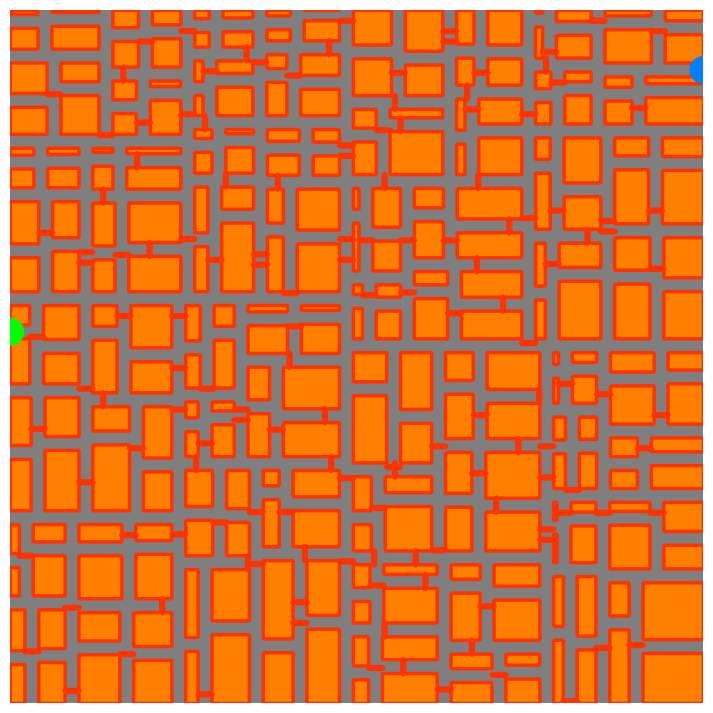

In [7]:
plt.figure(figsize=(9,9))
plt.imshow(cv2.cvtColor(maze_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()